<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
This notebook is designed specially for the module

ET5003 - MACHINE LEARNING APPLICATIONS 

Instructor: Enrique Naredo
###ET5003_BayesianNN

© All rights reserved to the author, do not share outside this module.


## Introduction

A [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network) (also known as a Bayes network, Bayes net, belief network, or decision network) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

* Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 
* For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. 
* Given symptoms, the network can be used to compute the probabilities of the presence of various diseases.

**Acknowledgement**

This notebook is refurbished taking source code from Alessio Benavoli's webpage and from the libraries numpy, GPy, pylab, and pymc3.

## Libraries

In [1]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# https://pypi.org/project/GPy/
!pip install gpy

     |████████████████████████████████| 959 kB 5.2 MB/s 
     |████████████████████████████████| 71 kB 7.3 MB/s 
  Created wheel for gpy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565100 sha256=1f810943b9e1419d3ec07c7fae1a04688b6c931395173c08cce6010fcbae5fea
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=d7b2ee4f7a54dce4cda6d28f4abfa860e1a6520f4e9ac92fe35982042a8c5bdf
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built gpy paramz


In [3]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm
%matplotlib inline

## Data generation
Generate data from a nonlinear function and use a Gaussian Process to sample it.

In [4]:
# seed the legacy random number generator
# to replicate experiments
seed = None
#seed = 7
np.random.seed(seed)

In [5]:
# Gaussian Processes
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
# Radial Basis Functions
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
# kernel is a function that specifies the degree of similarity 
# between variables given their relative positions in parameter space
kernel = GPy.kern.RBF(input_dim=1,lengthscale=0.15,variance=0.2)
print(kernel)

  rbf.         |  value  |  constraints  |  priors
  variance     |    0.2  |      +ve      |        
  lengthscale  |   0.15  |      +ve      |        


In [6]:
# number of samples
num_samples_train = 250 
num_samples_test = 200

# intervals to sample
a, b, c = 0.2, 0.6, 0.8
# points evenly spaced over [0,1]
interval_1 = np.random.rand(int(num_samples_train/2))*b - c
interval_2 = np.random.rand(int(num_samples_train/2))*b + c

X_new_train = np.sort(np.hstack([interval_1,interval_2])) 
X_new_test  = np.linspace(-1,1,num_samples_test)

X_new_all = np.hstack([X_new_train,X_new_test]).reshape(-1,1)

# vector of the means
μ_new = np.zeros((len(X_new_all)))
# covariance matrix
C_new = kernel.K(X_new_all,X_new_all)

# noise factor
noise_new = 0.1

# generate samples path with mean μ and covariance C
TF_new = np.random.multivariate_normal(μ_new,C_new,1)[0,:]
y_new_train = TF_new[0:len(X_new_train)] + np.random.randn(len(X_new_train))*noise_new
y_new_test = TF_new[len(X_new_train):] + np.random.randn(len(X_new_test))*noise_new
TF_new = TF_new[len(X_new_train):]

In this example, first generate a nonlinear functions and then generate noisy training data from that function.

The constrains are:
* Training samples $x$ belong to either interval $[-0.8,-0.2]$ or $[0.2,0.8]$.
* There is not data training samples from the interval $[-0.2,0.2]$. 
* The goal is to evaluate the extrapolation error outside in the interval  $[-0.2,0.2]$.

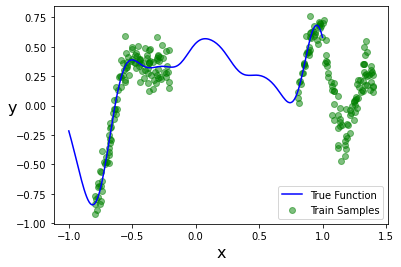

In [7]:
# plot 
pb.figure()
pb.plot(X_new_test,TF_new,c='b',label='True Function',zorder=100)
# training data
pb.scatter(X_new_train,y_new_train,c='g',label='Train Samples',alpha=0.5)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.legend()
pb.savefig("New_data.pdf")

## Bayesian NN
We address the previous nonlinear regression problem by using a Bayesian NN.

**The model is basically very similar to polynomial regression**. We first define the nonlinear function (NN)
and the place a prior over the unknown parameters. We then compute the posterior.

In [8]:
# https://theano-pymc.readthedocs.io/en/latest/
import theano

# add a column of ones to include an intercept in the model
x1 = np.vstack([np.ones(len(X_new_train)), X_new_train]).T


floatX = theano.config.floatX

l = 15
# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_1 = np.random.randn(x1.shape[1], l).astype(floatX)
init_out = np.random.randn(l).astype(floatX)

# pymc3 model as neural_network
with pm.Model() as neural_network:
    # we convert the data in theano type so we can do dot products with the correct type.
    ann_input = pm.Data('ann_input', x1)
    ann_output = pm.Data('ann_output', y_new_train)
    # Priors 
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_1', 0, sigma=10,
                             shape=(x1.shape[1], l), testval=init_1)
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_0', 0, sigma=10,
                              shape=(l,),testval=init_out)

    # Build neural-network using tanh activation function
    # Inner layer
    act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1))
    # Linear layer, like in Linear regression
    act_out = pm.Deterministic('act_out',pm.math.dot(act_1, weights_2_out))

    # standard deviation of noise
    sigma = pm.HalfCauchy('sigma',5)

    # Normal likelihood
    out = pm.Normal('out',
                       act_out,
                       sigma=sigma,
                       observed=ann_output)

In [9]:
# this can be slow because there are many parameters

# some parameters
par1 = 100  # start with 100, then use 1000+
par2 = 1000 # start with 1000, then use 10000+

# neural network
with neural_network:
    posterior = pm.sample(par1,tune=par2,chains=1)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, w_0, w_1]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 211 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.6371360905625714, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


Specifically, PyMC3 supports the following Variational Inference (VI) methods:

  * Automatic Differentiation Variational Inference (ADVI): 'advi'
  * ADVI full rank: 'fullrank_advi'
  * Stein Variational Gradient Descent (SVGD): 'svgd'
  * Amortized Stein Variational Gradient Descent (ASVGD): 'asvgd'
  * Normalizing Flow with default scale-loc flow (NFVI): 'nfvi'


In [10]:
# we can do instead an approximated inference
param3 = 1000 # start with 1000, then use 50000+
VI = 'advi'  # 'advi', 'fullrank_advi', 'svgd', 'asvgd', 'nfvi'
OP = pm.adam # pm.adam, pm.sgd, pm.adagrad, pm.adagrad_window, pm.adadelta
LR = 0.01    

with neural_network:
    approx = pm.fit(param3, method=VI, obj_optimizer=pm.adam(learning_rate=LR))

Finished [100%]: Average Loss = 583.64


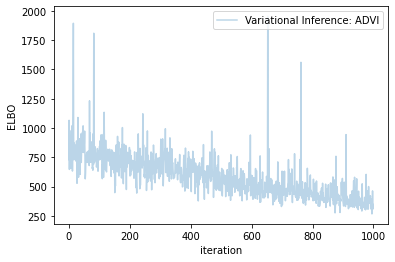

In [24]:
# plot 
pb.plot(approx.hist, label='Variational Inference: '+ VI.upper(), alpha=.3)
pb.legend(loc='upper right')
# Evidence Lower Bound (ELBO)
# https://en.wikipedia.org/wiki/Evidence_lower_bound
pb.ylabel('ELBO')
pb.xlabel('iteration');

In [12]:
# draw samples from variational posterior
D = 500
posterior = approx.sample(draws=D)

Now, we compute the prediction for each sample. 
* Note that we use `np.tanh` instead of `pm.math.tanh`
for speed reason. 
* `pm.math.tanh` is slower outside a Pymc3 model because it converts all data in theano format.
* It is convenient to do GPU-based training, but it is slow when we only need to compute predictions.

In [13]:
# add a column of ones to include an intercept in the model
x2 = np.vstack([np.ones(len(X_new_test)), X_new_test]).T

y_pred = []
for i in range(posterior['w_1'].shape[0]):
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x2.T))
    #outer layer
    y_pred.append(np.dot(posterior['w_0'][i,:],t1))

# predictions   
y_pred = np.array(y_pred)

We first plot the mean  of `y_pred`, this is very similar to the prediction that Keras returns

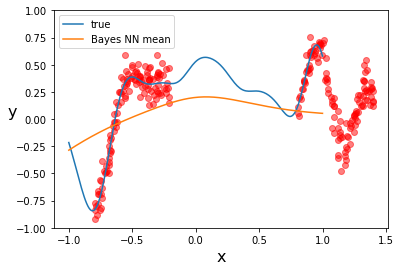

In [14]:
# plot
pb.plot(X_new_test,TF_new,label='true')
pb.plot(X_new_test,y_pred.mean(axis=0),label='Bayes NN mean')
pb.scatter(X_new_train,y_new_train,c='r',alpha=0.5)
pb.legend()
pb.ylim([-1,1])
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.savefig("BayesNN_mean.pdf")

Now, we plot the uncertainty, by plotting N nonlinear regression lines from the posterior

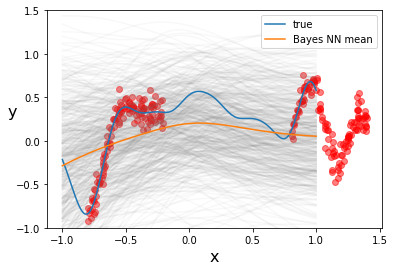

In [15]:
# plot
pb.plot(X_new_test,TF_new,label='true',Zorder=100)
pb.plot(X_new_test,y_pred.mean(axis=0),label='Bayes NN mean',Zorder=100)


N = 500
# nonlinear regression lines
for i in range(N):
    pb.plot(X_new_test,y_pred[i,:],c='gray',alpha=0.05)

pb.scatter(X_new_train,y_new_train,c='r',alpha=0.5)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.ylim([-1,1.5])
pb.legend()
pb.savefig("BayesNN_samples.pdf")

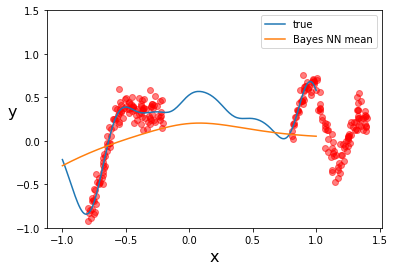

In [25]:
# plot
pb.plot(X_new_test,TF_new,label='true',Zorder=100)
pb.plot(X_new_test,y_pred.mean(axis=0),label='Bayes NN mean',Zorder=100)
pb.scatter(X_new_train,y_new_train,c='r',alpha=0.5)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.ylim([-1,1.5])
pb.legend()
pb.savefig("BayesNN_mean.pdf")